In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import pickle

import tensorflow as tf

import os

In [3]:
print(tf.version.VERSION)

tf.config.run_functions_eagerly(True)

2.4.1


In [4]:
gpus = tf.config.list_physical_devices('GPU')

print(gpus)
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]


In [5]:
with open('../data/var1.pkl', 'rb') as file:
    train_data, test_data, e_params, t_params, ft_params = pickle.load(file)

In [6]:
# операция обратная стандартизации для восстановления результата
def restore_result(e_vals):
    return e_vals * e_params[1] + e_params[0]

# Dataset

In [7]:
def split_time_series(series, input_width, label_width,
                         step, input_columns, label_columns):
    
    window_size = input_width + label_width
    
    res_len = (len(series) - window_size) // step + 1
    
    x = np.zeros((res_len, input_width, len(input_columns)))
    y = np.zeros((res_len, label_width, len(label_columns)))
    
    for i in range(res_len):
        x[i] = series[i * step: i * step + input_width, input_columns]
        y[i] = series[i * step + input_width : 
                      i * step + window_size, label_columns]
        
    return x, y

In [8]:
'''
def create_dataset(train_series, test_series, 
                   input_width, label_width, step,
                   input_columns, label_columns):
    
    x_train, y_train = split_time_series(train_series, 
                                         input_width, label_width,
                                         step, input_columns, label_columns)
    
    total_series = np.concatenate([train_series, test_series])
    total_series = total_series[len(train_series) - (input_width + label_width) + step :]
    
    x_test, y_test = split_time_series(total_series, 
                                         input_width, label_width,
                                         step, input_columns, label_columns)
    
    return x_train, y_train, x_test, y_test
'''

print()

In [9]:
INPUT_WIDTH = 30
LABEL_WIDTH = 1
STEP = 1

INPUT_COLUMNS = [0, 1, 2, 3, 8, 9, 10, 11, 12, 13]
LABEL_COLUMNS = [0, 1]

In [10]:
'''
x_train, y_train, x_test, y_test = create_dataset(train_data.to_numpy(), test_data.to_numpy(), 
                                                     INPUT_WIDTH, LABEL_WIDTH, STEP,
                                                     INPUT_COLUMNS, LABEL_COLUMNS)
'''

x_train, y_train = split_time_series(train_data.to_numpy(),
                                     INPUT_WIDTH, LABEL_WIDTH,
                                     STEP, INPUT_COLUMNS, LABEL_COLUMNS)
x_test, y_test = split_time_series(test_data.to_numpy(),
                                     INPUT_WIDTH, LABEL_WIDTH,
                                     STEP, INPUT_COLUMNS, LABEL_COLUMNS)

print(x_train.shape, y_train.shape, '\n', x_test.shape, y_test.shape)

(1796, 30, 10) (1796, 1, 2) 
 (335, 30, 10) (335, 1, 2)


# Model

In [11]:
# tf.keras.utils.set_random_seed(10)

BATCH_SIZE = 1
MAX_EPOCHS = 1000

In [12]:
def build_model1():
    
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(units=16, activation='tanh'),
        
        tf.keras.layers.Dense(units=LABEL_WIDTH * len(LABEL_COLUMNS)),
        
        tf.keras.layers.Reshape([LABEL_WIDTH, len(LABEL_COLUMNS)])
    ])
    
    model.build(input_shape=(BATCH_SIZE, INPUT_WIDTH, len(INPUT_COLUMNS)))
    
    model.compile(optimizer='adam', loss='mse')
    
    return model

def build_model2():
    
    input1 = tf.keras.layers.Input(shape=(INPUT_WIDTH, len(INPUT_COLUMNS), ))
    
    dense1 = tf.keras.layers.Dense(16, activation='relu')(input1)
    dense2 = tf.keras.layers.Dense(16, activation='relu')(input1)
    
    concat = tf.keras.layers.concatenate([dense1, dense2])
    output = tf.keras.layers.Dense(LABEL_WIDTH * len(LABEL_COLUMNS))(concat)
    
    model = tf.keras.Model(inputs=input1, outputs=output)
    
    return model

def build_model():    
    input1 = tf.keras.layers.Input(shape=(INPUT_WIDTH, len(INPUT_COLUMNS)))
    
    flatten = tf.keras.layers.Flatten()(input1)
    
    dense1 = tf.keras.layers.Dense(4, activation='relu')(flatten)
    
    dense2 = tf.keras.layers.Dense(16, activation='relu')(dense1)
    
    dense3 = tf.keras.layers.Dense(16, activation='relu')(dense2)
    
    output = tf.keras.layers.Dense(len(LABEL_COLUMNS))(dense3)
    
    reshape = tf.keras.layers.Reshape([LABEL_WIDTH, len(LABEL_COLUMNS)])(output)
    
    model = tf.keras.Model(inputs=input1, outputs=reshape)
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [13]:
model = build_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 10)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 1204      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
_________________________________________________________________
reshape (Reshape)            (None, 1, 2)              0     

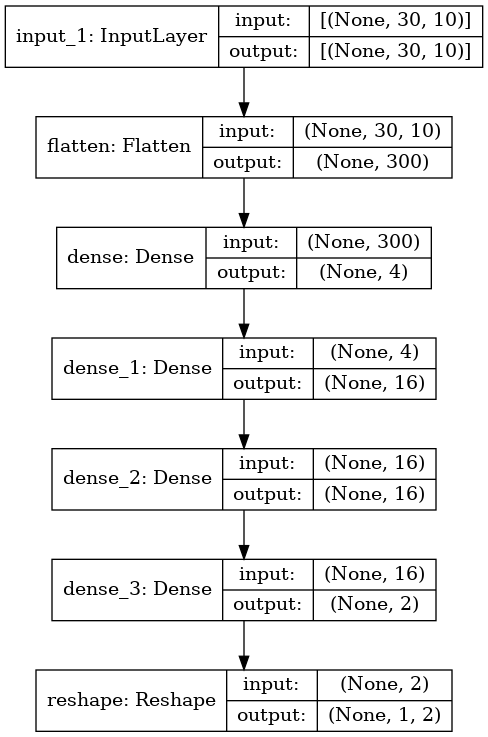

In [14]:
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
x = np.expand_dims(x_train[0], 0)

print(model(x))

tf.Tensor([[[-0.38281953 -0.6878952 ]]], shape=(1, 1, 2), dtype=float32)


In [16]:
model_num = 4
log_dir = "../models/mlp/{:02d}/logs/".format(model_num)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                         update_freq='batch')

In [17]:
checkpoint_name = "../models/mlp/" + "{:02d}".format(model_num) + "/checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_name)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath = checkpoint_name, 
                    verbose = 1, 
                    save_weights_only = True,
                    save_freq = 10 * len(x_train))

In [18]:
# latest = tf.train.latest_checkpoint(checkpoint_dir)

model.load_weights("../models/mlp/04/" + "checkpoints/cp-0160.ckpt")

In [ ]:
model.fit(x_train, y_train, 
          validation_data = (x_test, y_test),
          batch_size = BATCH_SIZE, 
          epochs = MAX_EPOCHS, 
          callbacks = [tensorboard_callback, cp_callback])

Epoch 1/1000
   9/1796 [..............................] - ETA: 25s - loss: 0.8734

/raid/shumnov/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1796/1796 [==============================] - 17s 10ms/step - loss: 0.3600 - val_loss: 0.1213
Epoch 2/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.1050 - val_loss: 0.1100
Epoch 3/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0876 - val_loss: 0.1037
Epoch 4/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0775 - val_loss: 0.1328
Epoch 5/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0702 - val_loss: 0.1036
Epoch 6/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0664 - val_loss: 0.0859
Epoch 7/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0644 - val_loss: 0.0915
Epoch 8/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0591 - val_loss: 0.0792
Epoch 9/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0539 - val_loss: 0.0700
Epoch 10/1000
1795/1796 [============================>.] - 

Epoch 70/1000
1795/1796 [============================>.] - ETA: 0s - loss: 0.0345
Epoch 00070: saving model to ../models/mlp/04/checkpoints/cp-0070.ckpt
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0345 - val_loss: 0.0506
Epoch 71/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0328 - val_loss: 0.0534
Epoch 72/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0336 - val_loss: 0.0508
Epoch 73/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0335 - val_loss: 0.0552
Epoch 74/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0343 - val_loss: 0.0514
Epoch 75/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0352 - val_loss: 0.0543
Epoch 76/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0326 - val_loss: 0.0564
Epoch 77/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0344 - val_loss: 0.0502
Epoch

1796/1796 [==============================] - 17s 10ms/step - loss: 0.0324 - val_loss: 0.0560
Epoch 138/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0310 - val_loss: 0.0486
Epoch 139/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0311 - val_loss: 0.0510
Epoch 140/1000
1795/1796 [============================>.] - ETA: 0s - loss: 0.0306
Epoch 00140: saving model to ../models/mlp/04/checkpoints/cp-0140.ckpt
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0306 - val_loss: 0.0521
Epoch 141/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0308 - val_loss: 0.0555
Epoch 142/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0322 - val_loss: 0.0536
Epoch 143/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0306 - val_loss: 0.0512
Epoch 144/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0324 - val_loss: 0.0492
Epoch 145/10

Epoch 204/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0288 - val_loss: 0.0574
Epoch 205/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0289 - val_loss: 0.0524
Epoch 206/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0314 - val_loss: 0.0475
Epoch 207/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0304 - val_loss: 0.0531
Epoch 208/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0294 - val_loss: 0.0511
Epoch 209/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0305 - val_loss: 0.0532
Epoch 210/1000
1795/1796 [============================>.] - ETA: 0s - loss: 0.0296
Epoch 00210: saving model to ../models/mlp/04/checkpoints/cp-0210.ckpt
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0296 - val_loss: 0.0493
Epoch 211/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0305 - val_loss: 0.04

Epoch 271/1000
1796/1796 [==============================] - 20s 11ms/step - loss: 0.0281 - val_loss: 0.0544
Epoch 272/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0278 - val_loss: 0.0540
Epoch 273/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0290 - val_loss: 0.0525
Epoch 274/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0297 - val_loss: 0.0519
Epoch 275/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0307 - val_loss: 0.0539
Epoch 276/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0290 - val_loss: 0.0512
Epoch 277/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0288 - val_loss: 0.0527
Epoch 278/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0296 - val_loss: 0.0518
Epoch 279/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0290 - val_loss: 0.0531
Epoch 280/1000
1795/1796 [==

1796/1796 [==============================] - 17s 10ms/step - loss: 0.0298 - val_loss: 0.0551
Epoch 340/1000
1793/1796 [============================>.] - ETA: 0s - loss: 0.0290
Epoch 00340: saving model to ../models/mlp/04/checkpoints/cp-0340.ckpt
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0290 - val_loss: 0.0509
Epoch 341/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0274 - val_loss: 0.0517
Epoch 342/1000
1796/1796 [==============================] - 17s 10ms/step - loss: 0.0308 - val_loss: 0.0554
Epoch 343/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0293 - val_loss: 0.0524
Epoch 344/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0273 - val_loss: 0.0524
Epoch 345/1000
1796/1796 [==============================] - 19s 11ms/step - loss: 0.0291 - val_loss: 0.0496
Epoch 346/1000
1796/1796 [==============================] - 18s 10ms/step - loss: 0.0299 - val_loss: 0.0528
Epoch 347/10

In [18]:
from matplotlib import pyplot as plt

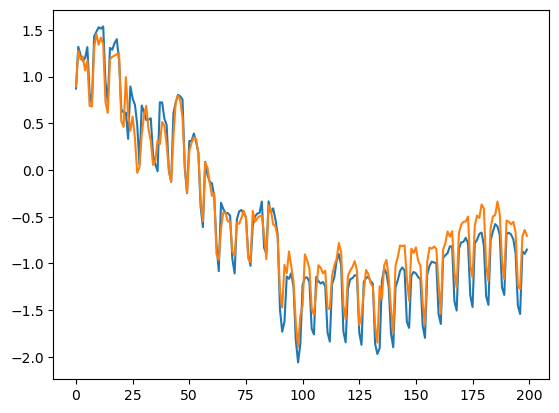

In [19]:
plt.plot(np.squeeze(y_train)[:200,0])
plt.plot(np.squeeze(model(x_train))[:200,0])

plt.show()

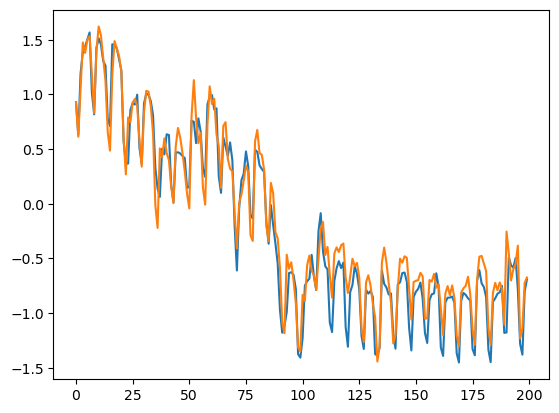

In [21]:
plt.plot(np.squeeze(y_test)[:200,0])
plt.plot(np.squeeze(model(x_test))[:200,0])

plt.show()

In [23]:
from sklearn.metrics import mean_squared_error as mae

In [24]:
print(mae(np.squeeze(y_train),
             np.squeeze(model(x_train))))

print(mae(np.squeeze(y_test),
             np.squeeze(model(x_test))))

0.032338638016336095
0.05268979800939815


In [20]:
def predict():
    total_series = np.concatenate([train_data, test_data])
    total_series = total_series[len(train_data) - INPUT_WIDTH :]
    
    predicted = np.zeros((len(test_data)))
    
    for i in range(len(predicted)):
        x = np.expand_dims(total_series[i : i + INPUT_WIDTH, INPUT_COLUMNS], 0)
        y = model(x)
        
        predicted[i] = y[0, 0, 0]
        total_series[i + INPUT_WIDTH, 1] = y[0, 0, 1]
        
    predicted = restore_result(predicted)
        
    return predicted

# Evaluate

In [21]:
predicted = predict()

ground_truth = restore_result(test_data.to_numpy()[:,0])

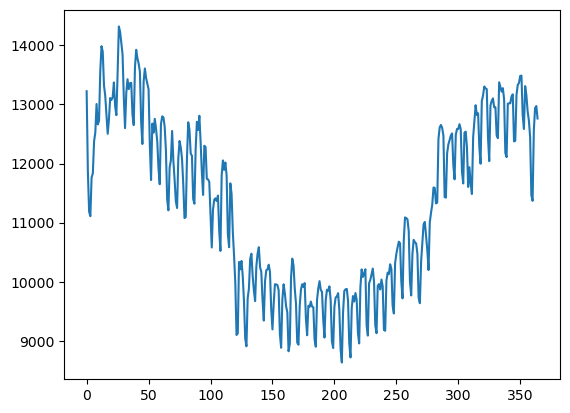

In [22]:
plt.plot(predicted)

plt.show()

            |    RMSE    |  MAPE (%)  | PBias (%)  |     R2     
------------|------------|------------|------------|------------
   SNAIVE   |  355.682   |   2.444    |   0.528    |   0.948    



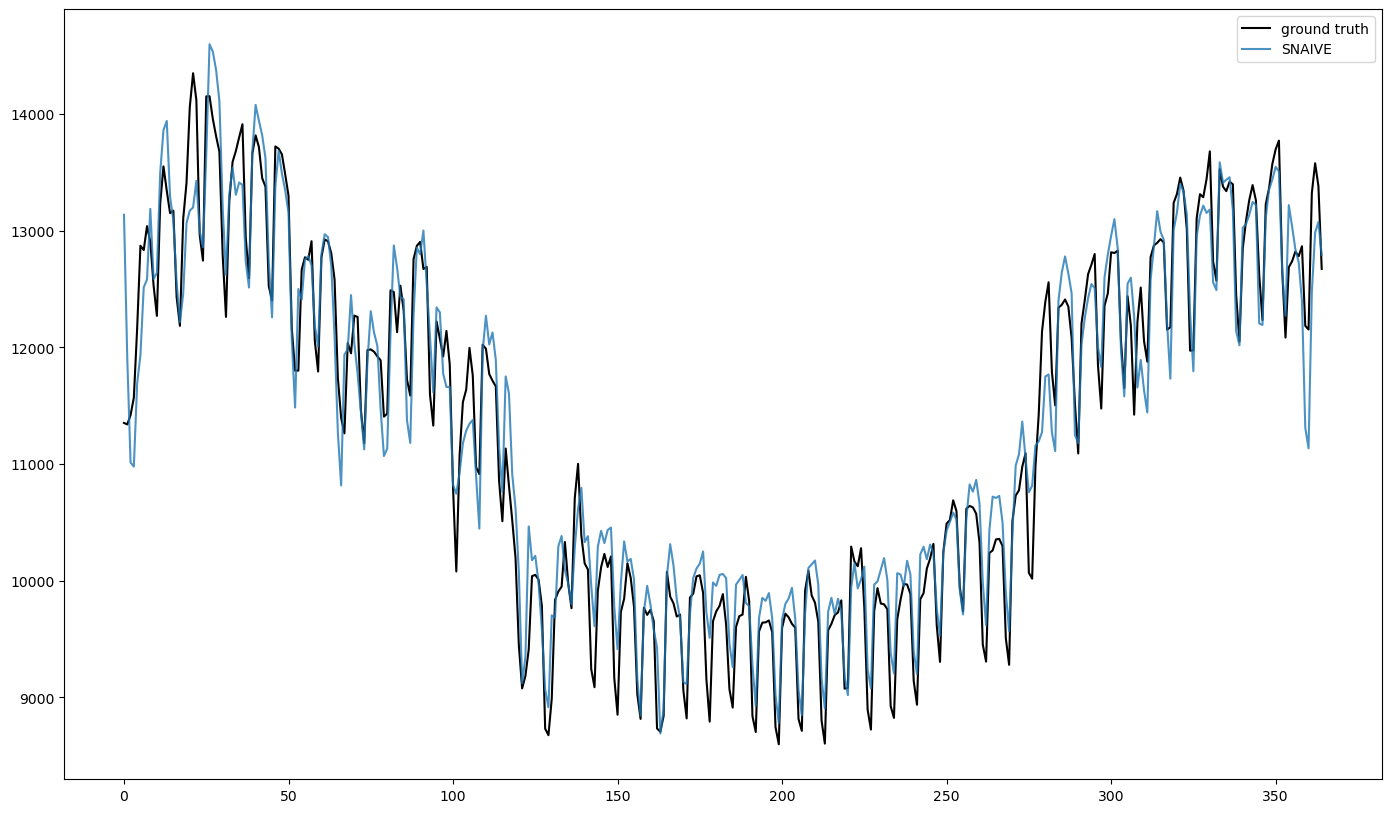

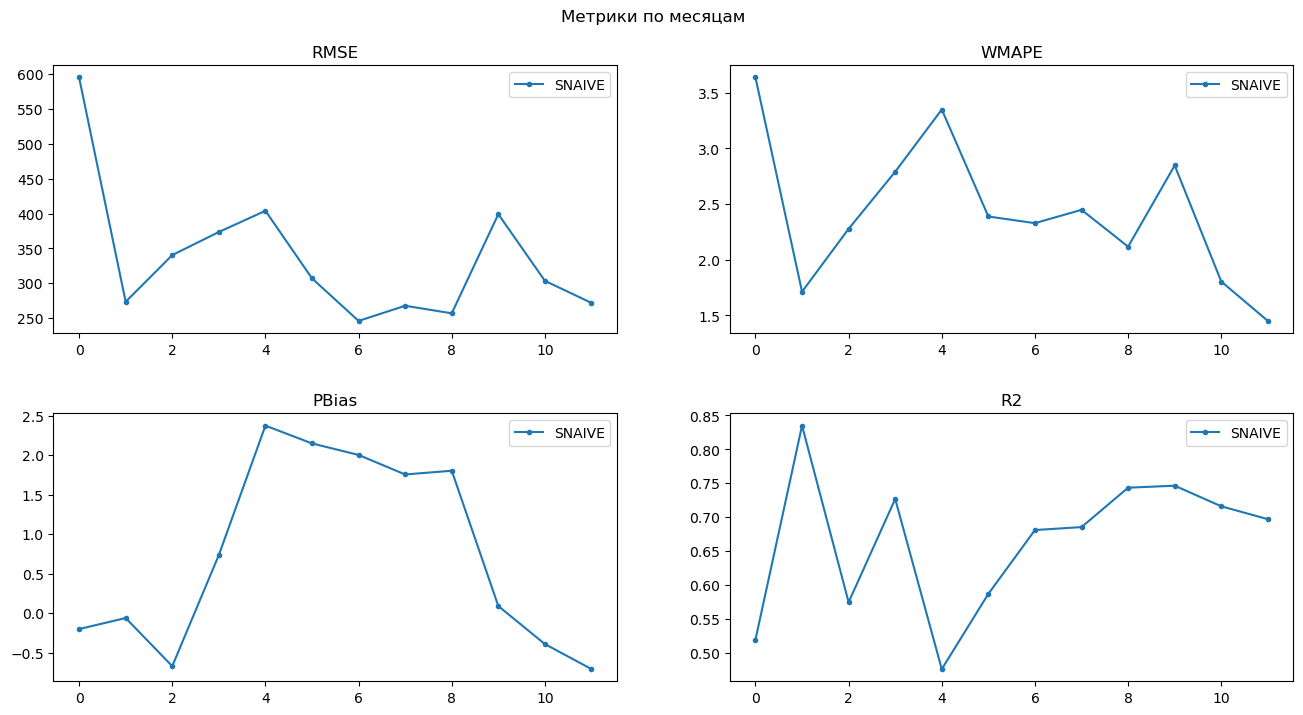

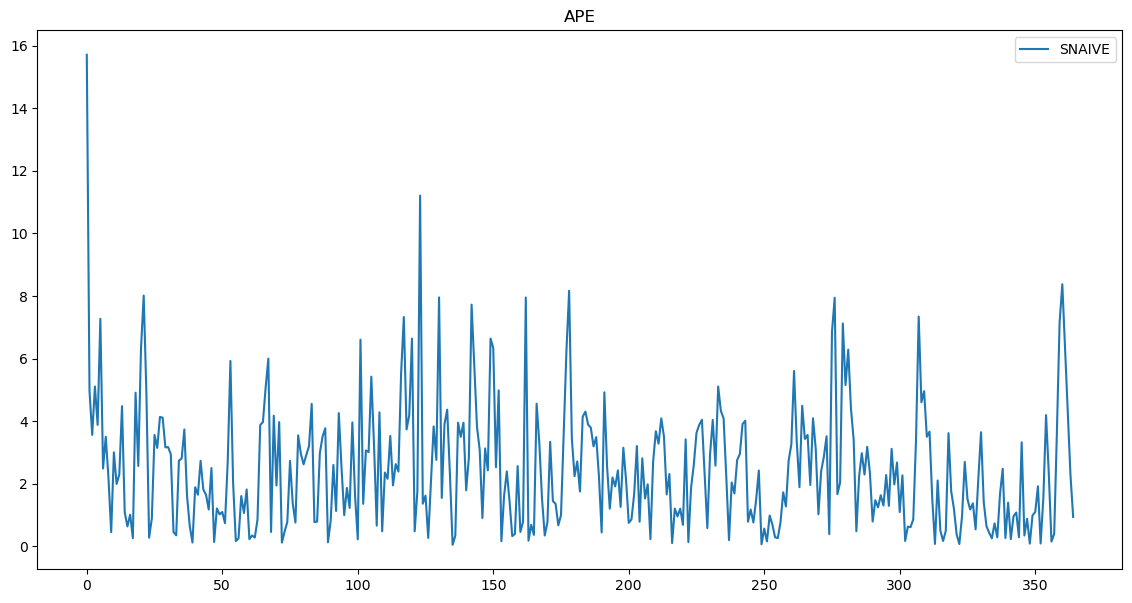

In [34]:
%run evaluate_forecasts.ipynb

evaluate_forecasts(ground_truth, [predicted], ['SNAIVE'])